## Use `Ocetrac` to identify and track marine heatwaves

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask.array as da
import ocetrac

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings('ignore')

### Import preprocessed data 

In [2]:
ds = xr.open_dataset('01_preprocessed.nc', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:           (time: 478, lat: 720, lon: 1440, month: 12)
Coordinates:
  * lon               (lon) float32 0.125 0.375 0.625 ... 359.4 359.6 359.9
  * lat               (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * time              (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    features_notrend  (time, lat, lon) float64 ...
    ssta_notrend      (time, lat, lon) float64 ...
    stdev             (month, lat, lon) float64 ...
    mask              (lat, lon) bool ...
Attributes:
    description:  OISST v2.1 preprocessed for Ocetrac
    threshold:    90th percentile
    climatology:  entire period

In [3]:
%%time 
features = ds.features_notrend
features.load()

CPU times: user 0 ns, sys: 1.25 s, total: 1.25 s
Wall time: 1.26 s


<xarray.DataArray 'features_notrend' (time: 478, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * time     (time) datetime64[ns] 1981-09-01 1981-10-01 ... 2021-06-01

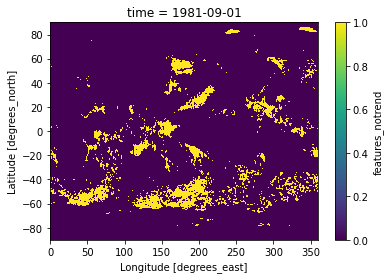

In [6]:
# Binary conversion
binary_out = np.isfinite(features)
binary_out.isel(time=0).plot()

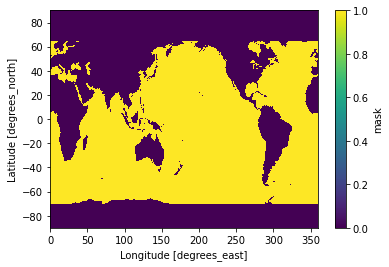

In [16]:
mask = ds.mask.where((ds.lat<65) & (ds.lat>-70), drop=False, other=0) 
mask.plot()

In [17]:
%%time
Tracker = ocetrac.Tracker(binary_out, mask, radius=8, min_size_quartile=0.75, timedim='time', xdim='lon', ydim='lat', positive=True)
blobs = Tracker.track()

minimum area: 2505.0
inital objects identified 	 13161
final objects tracked 	 832
CPU times: user 9min 54s, sys: 2min 19s, total: 12min 14s
Wall time: 12min 16s


In [18]:
blobs.attrs

{'inital objects identified': 13161,
 'final objects tracked': 832,
 'radius': 8,
 'size quantile threshold': 0.75,
 'min area': 2505.0,
 'percent area reject': 0.2017659936328879,
 'percent area accept': 0.7982340063671121}

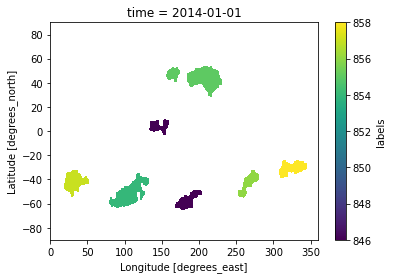

In [11]:
blobs.sel(time='01-01-2014').plot()

In [13]:
from matplotlib.colors import ListedColormap
maxl = int(np.nanmax(blobs.values))
cm = ListedColormap(np.random.random(size=(maxl, 3)).tolist())


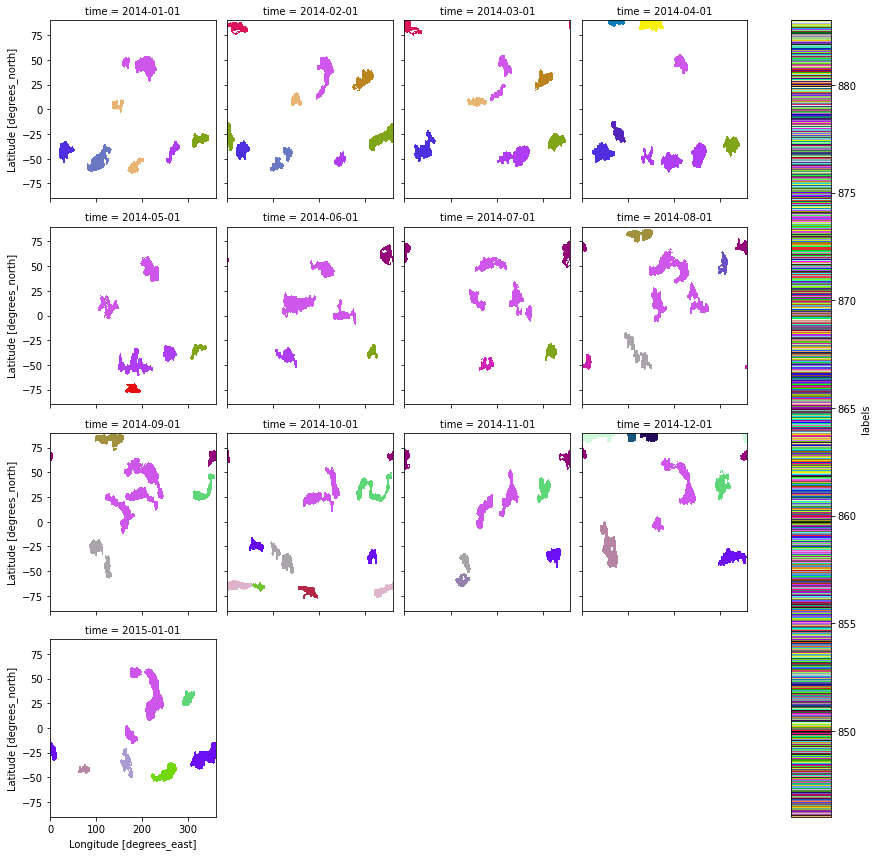

In [15]:
blobs.sel(time=slice('01-01-2014', '01-01-2015')).plot(col='time', col_wrap=4, cmap=cm)

In [19]:
blobs.to_netcdf('02_tracked.nc', mode='w')


In [ ]:

plt.figure(figsize=(16,3))
ax1 = plt.subplot(121);blobs.isel(time=0).plot(cmap= cm)
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax1.set_aspect('equal')
ax2 = plt.subplot(122); features_ssta.isel(time=0).plot(cmap='Reds', vmin=0, vmax=3);
mask.where(mask==0).plot.contourf(colors='k', add_colorbar=False); ax2.set_aspect('equal');

In [ ]:
id = 35
event = blobs.where(blobs==id, drop=True)
event.shape

In [ ]:
# Create intensity image for the Indian Ocean marine heatwave
event_intensity = ds.anom.isel(zlev=0).where((ds.time==event.time) & 
                                             (ds.lat==event.lat) & 
                                             (ds.lon==event.lon), 
                                             drop=True).load();
event_intensity = event_intensity.expand_dims(dim='intensity', axis=3)
events_contour = event.fillna(0)

plt.rc('font', size=12); plt.figure(figsize=(15,6));
for i in enumerate(range(1,len(event.time))):
    ax = plt.subplot(2,3,i[1],projection=ccrs.PlateCarree())
    event_intensity.isel(time=i[0], intensity=0).plot(transform=ccrs.PlateCarree(), vmin=-2, vmax=2,  
                                                      cmap='RdBu_r', extend='both', add_colorbar=True, add_labels=False)
    plt.title(event.isel(time=i[0]).time.values.astype('datetime64[D]'))
    ax.coastlines(resolution='110m', color='black', linewidth=1) 
    ax.add_feature(cfeature.LAND, facecolor='w');
    events_contour.isel(time=i[0]).plot.contour(levels=[34,35], transform=ccrs.PlateCarree(), colors='b', linewidths=4, add_colorbar=False, add_labels=False)

In [ ]:
mo = Tracker._morphological_operations()

In [ ]:
mo.isel(time=0).plot()